In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier

import numpy as np


In [2]:
X, y = load_digits(return_X_y=True)

In [3]:
model_underfitting = DecisionTreeClassifier(max_depth=1, random_state=42)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_overfitting = DecisionTreeClassifier(max_depth=None, random_state=42)

In [4]:
train_sizes_underfitting, train_scores_underfitting, test_scores_underfitting = (
    learning_curve(
        model_underfitting,
        X,
        y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="accuracy",
        n_jobs=-1,
    )
)

train_mean_underfitting = train_scores_underfitting.mean(axis=1)
train_std_underfitting = train_scores_underfitting.std(axis=1)
test_mean_underfitting = test_scores_underfitting.mean(axis=1)
test_std_underfitting = test_scores_underfitting.std(axis=1)

train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    model_rf,
    X,
    y,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
    n_jobs=-1,
)

train_mean_rf = train_scores_rf.mean(axis=1)
train_std_rf = train_scores_rf.std(axis=1)
test_mean_rf = test_scores_rf.mean(axis=1)
test_std_rf = test_scores_rf.std(axis=1)

train_sizes_overfitting, train_scores_overfitting, test_scores_overfitting = (
    learning_curve(
        model_overfitting,
        X,
        y,
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring="accuracy",
        n_jobs=-1,
        random_state=42,
    )
)

train_mean_overfitting = train_scores_overfitting.mean(axis=1)
train_std_overfitting = train_scores_overfitting.std(axis=1)
test_mean_overfitting = test_scores_overfitting.mean(axis=1)
test_std_overfitting = test_scores_overfitting.std(axis=1)

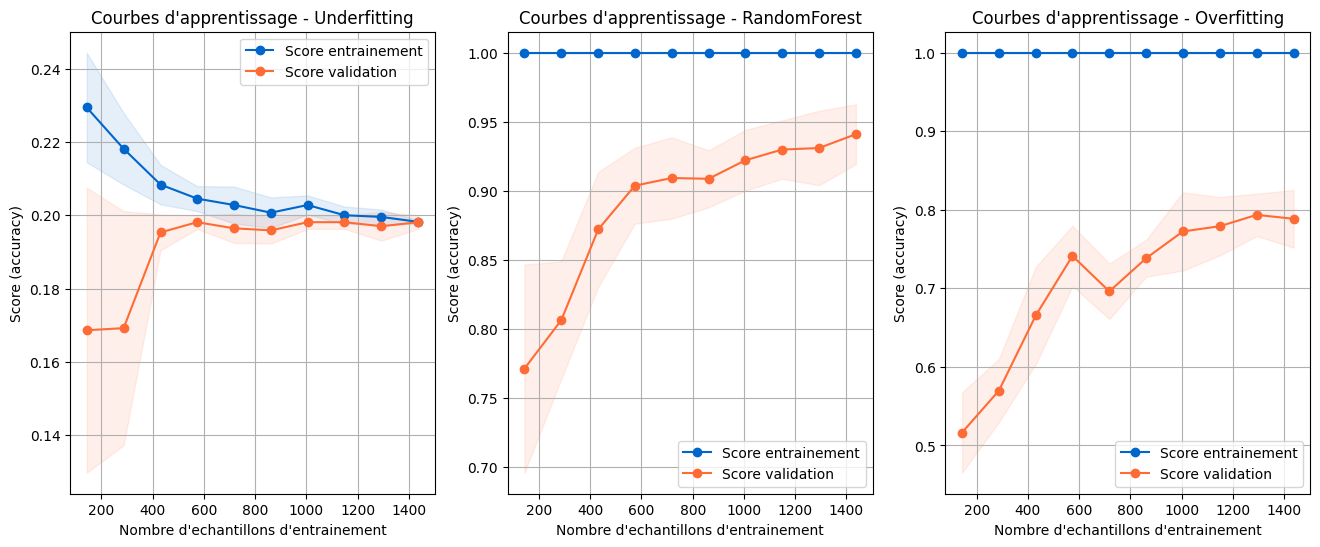

In [5]:
def create_plot(ax, train_sizes, train_mean, test_mean, train_std, test_std):
    ax.plot(
        train_sizes,
        train_mean,
        "o-",
        label="Score entrainement",
        color="#0066cc",
    )
    ax.plot(
        train_sizes,
        test_mean,
        "o-",
        label="Score validation",
        color="#ff6b35",
    )
    ax.fill_between(
        train_sizes,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="#0066cc",
    )
    ax.fill_between(
        train_sizes,
        test_mean - test_std,
        test_mean + test_std,
        alpha=0.1,
        color="#ff6b35",
    )
    ax.set_xlabel("Nombre d'echantillons d'entrainement")
    ax.set_ylabel("Score (accuracy)")
    ax.set_title("Courbes d'apprentissage")
    ax.legend(loc="best")
    ax.grid(True)


fig, axes = plt.subplots(1, 3, figsize=(16, 6))

ax1 = axes[0]
create_plot(
    ax1,
    train_sizes_underfitting,
    train_mean_underfitting,
    test_mean_underfitting,
    train_std_underfitting,
    test_std_underfitting,
)
ax1.set_title("Courbes d'apprentissage - Underfitting")

ax2 = axes[1]
create_plot(
    ax2,
    train_sizes_rf,
    train_mean_rf,
    test_mean_rf,
    train_std_rf,
    test_std_rf,
)
ax2.set_title("Courbes d'apprentissage - RandomForest")

ax3 = axes[2]
create_plot(
    ax3,
    train_sizes_overfitting,
    train_mean_overfitting,
    test_mean_overfitting,
    train_std_overfitting,
    test_std_overfitting,
)
ax3.set_title("Courbes d'apprentissage - Overfitting")

plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_underfitting.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_overfitting.fit(X_train, y_train)

y_proba_underfitting = model_underfitting.predict_proba(X_test)
y_proba_rf = model_rf.predict_proba(X_test)
y_proba_overfitting = model_overfitting.predict_proba(X_test)

# Binarisation des labels
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# Calcul AUC macro
auc_macro_underfitting = roc_auc_score(
    y_test_bin, y_proba_underfitting, multi_class="ovr"
)
auc_macro_rf = roc_auc_score(y_test_bin, y_proba_rf, multi_class="ovr")
auc_macro_overfitting = roc_auc_score(
    y_test_bin, y_proba_overfitting, multi_class="ovr"
)
print(f"Underfitting AUC macro (One-vs-Rest) : {auc_macro_underfitting}")
print(f"RandomForest AUC macro (One-vs-Rest) : {auc_macro_rf}")
print(f"Overfitting AUC macro (One-vs-Rest) : {auc_macro_overfitting}")

Underfitting AUC macro (One-vs-Rest) : 0.6124529034756073
RandomForest AUC macro (One-vs-Rest) : 0.9992120259839874
Overfitting AUC macro (One-vs-Rest) : 0.9024036658484544


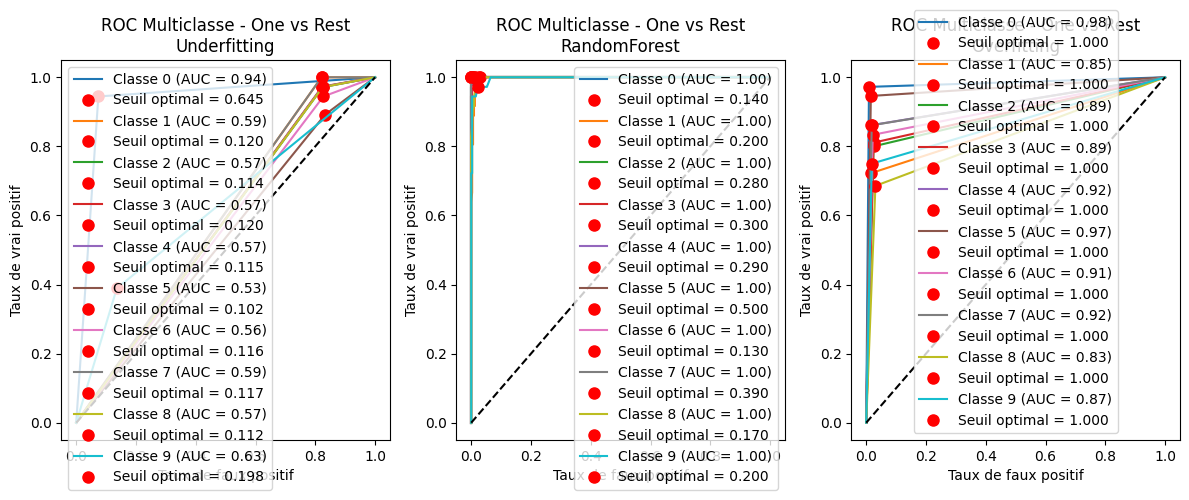

In [21]:
def create_roc_curve(ax, classes, y_test_bin, y_proba):
    for i, classe in enumerate(classes):
        fpr, tpr, threshold = roc_curve(y_test_bin[:, i], y_proba[:, i])
        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = threshold[optimal_idx]
        y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
        auc_score = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
        ax.plot(fpr, tpr, label=f"Classe {classe} (AUC = {auc_score:.2f})")
        ax.plot(
            fpr[optimal_idx],
            tpr[optimal_idx],
            "ro",
            markersize=8,
            label=f"Seuil optimal = {optimal_threshold:.3f}",
        )

    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("Taux de faux positif")
    ax.set_ylabel("Taux de vrai positif")
    ax.set_title("ROC Multiclasse - One vs Rest")
    ax.legend()


fig, axes = plt.subplots(1, 3, figsize=(12, 5))

create_roc_curve(axes[0], classes, y_test_bin, y_proba_underfitting)
axes[0].set_title("ROC Multiclasse - One vs Rest\nUnderfitting")
create_roc_curve(axes[1], classes, y_test_bin, y_proba_rf)
axes[1].set_title("ROC Multiclasse - One vs Rest\nRandomForest")
create_roc_curve(axes[2], classes, y_test_bin, y_proba_overfitting)
axes[2].set_title("ROC Multiclasse - One vs Rest\nOverfitting")

plt.tight_layout()
plt.show()